This notebook contains an example for teaching.


# Automatic Machine Learning with H2O AutoML using Wage Data from 2015

We illustrate how to predict an outcome variable Y in a high-dimensional setting, using the AutoML package *H2O* that covers the complete pipeline from the raw dataset to the deployable machine learning model. In last few years, AutoML or automated machine learning has become widely popular among data science community. 

We can use AutoML as a benchmark and compare it to the methods that we used in the previous notebook where we applied one machine learning method after the other.

In [4]:
# Import relevant packages
import pandas as pd
import numpy as np
import pyreadr
from sklearn import preprocessing
import patsy

from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

In [2]:
# load the H2O package
import h2o

# start h2o cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,26 secs
H2O_cluster_timezone:,America/Lima
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_started_from_R_MSI-NB_cvt075
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.965 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [5]:
# load dataset
rdata_read = pyreadr.read_r("../data/wage2015_subsample_inference.Rdata")
data = rdata_read[ 'data' ]
n = data.shape[0]

type(data)

pandas.core.frame.DataFrame

In [14]:
# Import relevant packages for splitting data
import random
import math

# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(0)
random = np.random.randint(0, data.shape[0], size=math.floor(data.shape[0]))
data["random"] = random
random    # the array does not change 
data_2 = data.sort_values(by=['random'])


In [15]:
# Create training and testing sample 
train = data_2[ : math.floor(n*3/4)]    # training sample
test =  data_2[ math.floor(n*3/4) : ]   # testing sample
print(data_train.shape)
print(data_test.shape)

(3862, 21)
(1288, 21)


In [16]:
# start h2o cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,7 mins 36 secs
H2O_cluster_timezone:,America/Lima
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_started_from_R_MSI-NB_cvt075
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.965 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [20]:
# convert data as h2o type
train_h = h2o.H2OFrame(train)
test_h = h2o.H2OFrame(test)

# have a look at the data
train_h.describe()


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:3862
Cols:21




,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2,random
type,real,real,int,int,int,int,int,int,int,int,int,int,real,real,real,real,int,int,int,int,int
mins,3.021978021978022,1.1059115911497213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,370.0,2.0,0.0
mean,23.465417731467202,2.969427791239379,0.446918694976696,0.023562920766442258,0.24702226825479026,0.2780942516830658,0.3125323666494045,0.13878819264629724,0.2553081305023304,0.29829104091144487,0.21569135163127914,0.23070947695494562,13.672190574831728,2.9923032107716137,8.15417316157433,24.849760334671146,5243.418436043504,11.69135163127914,6667.996116002073,13.333764888658706,1914.2263076126374
maxs,528.845673076923,6.270696655981913,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,47.0,22.09,103.823,487.9681,100000.0,22.0,100000.0,22.0,3825.0
sigma,21.430085743506766,0.5750893708933925,0.4972387709704293,0.15170256601034887,0.4313356487428773,0.44811810407097313,0.46358551980855045,0.3457701367976389,0.436090737870262,0.45756716236312467,0.4113543571812672,0.4213414081729523,10.598613687032655,3.987480265404191,14.424744487903597,53.27996156215637,11579.91114662104,6.9783416585657125,5588.264282354911,5.691380293915183,1104.7025392074318
zeros,0,0,2136,3771,2908,2788,2655,3326,2876,2710,3029,2971,48,48,48,48,0,0,0,0,3
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,26.442307692307693,3.274965291519244,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,29.0,8.41,24.389,70.7281,340.0,1.0,8660.0,20.0,0.0
1,19.23076923076923,2.9565115604007097,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,33.5,11.2225,37.595375,125.94450625,9620.0,22.0,1870.0,5.0,0.0
2,48.07692307692308,3.872802292274865,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.04,0.008,0.0016,3060.0,10.0,8190.0,18.0,0.0


In [33]:
# define the variables
y = 'lwage'

data_columns = list(data)
no_relev_col = ['wage','occ2', 'ind2', 'random', 'lwage']

# This gives us: new_list = ['carrot' , 'lemon']
x = [col for col in data_columns if col not in no_relev_col]
x

['sex',
 'shs',
 'hsg',
 'scl',
 'clg',
 'ad',
 'mw',
 'so',
 'we',
 'ne',
 'exp1',
 'exp2',
 'exp3',
 'exp4',
 'occ',
 'ind']

In [34]:
# run AutoML for 10 base models and a maximal runtime of 100 seconds
# Run AutoML for 30 seconds
aml = H2OAutoML(max_runtime_secs = 100, max_models = 10, seed = 1)
aml.train(x = x, y = y, training_frame = train_h, leaderboard_frame = test_h)


AutoML progress: |█
10:14:46.157: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████| 100%


In [36]:
# AutoML Leaderboard
lb = aml.leaderboard
print(lb)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20210420_101446,0.221702,0.470853,0.221702,0.354219,0.120551
StackedEnsemble_BestOfFamily_AutoML_20210420_101446,0.222035,0.471206,0.222035,0.354997,0.120632
GBM_2_AutoML_20210420_101446,0.222557,0.471759,0.222557,0.355784,0.120716
GBM_1_AutoML_20210420_101446,0.224113,0.473406,0.224113,0.355508,0.121266
GBM_3_AutoML_20210420_101446,0.225445,0.474811,0.225445,0.360304,0.121396
GBM_grid__1_AutoML_20210420_101446_model_1,0.227392,0.476856,0.227392,0.360741,0.122053
GBM_5_AutoML_20210420_101446,0.227814,0.477298,0.227814,0.361795,0.122064
GBM_4_AutoML_20210420_101446,0.230396,0.479996,0.230396,0.363723,0.122735
XRT_1_AutoML_20210420_101446,0.233375,0.483089,0.233375,0.366466,0.123541
DRF_1_AutoML_20210420_101446,0.249188,0.499187,0.249188,0.380378,0.127543


We see that two Stacked Ensembles are at the top of the leaderboard. Stacked Ensembles often outperform a single model. The out-of-sample (test) MSE of the leading model is given by

In [41]:
aml.leaderboard['mse'][0,0]

0.22170242200808812

The in-sample performance can be evaluated by

In [42]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20210420_101446

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.15336801468296055
RMSE: 0.3916222857332822
MAE: 0.2975878045344056
RMSLE: 0.10083443761679912
R^2: 0.5361510490339878
Mean Residual Deviance: 0.15336801468296055
Null degrees of freedom: 3861
Residual degrees of freedom: 3854
Null deviance: 1276.9399854672324
Residual deviance: 592.3072727055936
AIC: 3736.9598054643016

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.2230823259224694
RMSE: 0.4723159174985207
MAE: 0.35789650487089536
RMSLE: 0.12041317556810448
R^2: 0.32530584638448745
Mean Residual Deviance: 0.2230823259224694
Null degrees of freedom: 3861
Residual degrees of freedom: 3854
Null deviance: 1277.1043650451534
Residual deviance: 861.5439427125768
AIC: 5184.053213386263


This is in line with our previous results. To understand how the ensemble works, let's take a peek inside the Stacked Ensemble "All Models" model.  The "All Models" ensemble is an ensemble of all of the individual models in the AutoML run.  This is often the top performing model on the leaderboard.

In [95]:
model_ids = h2o.as_list(aml.leaderboard['model_id'][0], use_pandas=True)


In [141]:
model = model_ids[model_ids['model_id'].str.contains("StackedEnsemble_AllModels")].values.tolist()
model_id = model[0][0]
model_id

'StackedEnsemble_AllModels_AutoML_20210420_101446'

In [142]:
se = h2o.get_model('StackedEnsemble_AllModels_AutoML_20210420_101446')
se

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20210420_101446

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.15336801468296055
RMSE: 0.3916222857332822
MAE: 0.2975878045344056
RMSLE: 0.10083443761679912
R^2: 0.5361510490339878
Mean Residual Deviance: 0.15336801468296055
Null degrees of freedom: 3861
Residual degrees of freedom: 3854
Null deviance: 1276.9399854672324
Residual deviance: 592.3072727055936
AIC: 3736.9598054643016

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.2230823259224694
RMSE: 0.4723159174985207
MAE: 0.35789650487089536
RMSLE: 0.12041317556810448
R^2: 0.32530584638448745
Mean Residual Deviance: 0.2230823259224694
Null degrees of freedom: 3861
Residual degrees of freedom: 3854
Null deviance: 1277.1043650451534
Residual deviance: 861.5439427125768
AIC: 5184.053213386263


In [147]:
# Get the Stacked Ensemble metalearner model
metalearner = se.metalearner()
metalearner

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  metalearner_AUTO_StackedEnsemble_AllModels_AutoML_20210420_101446


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,"Elastic Net (alpha = 0.5, lambda = 2.258E-4 )",10,7,1,levelone_training_StackedEnsemble_AllModels_AutoML_20210420_101446




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.22285575425627957
RMSE: 0.47207600474529476
MAE: 0.3577168118937625
RMSLE: 0.12034524870031442
R^2: 0.3259910937609637
Mean Residual Deviance: 0.22285575425627957
Null degrees of freedom: 3861
Residual degrees of freedom: 3854
Null deviance: 1276.9399854672324
Residual deviance: 860.6689229377517
AIC: 5180.128812717147

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 0.2230823259224694
RMSE: 0.4723159174985207
MAE: 0.35789650487089536
RMSLE: 0.12041317556810448
R^2: 0.32530584638448745
Mean Residual Deviance: 0.2230823259224694
Null degrees of freedom: 3861
Residual degrees of freedom: 3854
Null deviance: 1277.1043650451534
Residual deviance: 861.5439427125768
AIC: 5184.053213386263

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.3579374,0.01058328,0.36069974,0.36608687,0.33996028,0.35787547,0.36506465
1,mean_residual_deviance,0.22335783,0.019000858,0.23923838,0.22691321,0.19703366,0.21159321,0.2420107
2,mse,0.22335783,0.019000858,0.23923838,0.22691321,0.19703366,0.21159321,0.2420107
3,null_deviance,255.42087,18.944805,270.14395,279.33765,235.1926,252.05312,240.37706
4,r2,0.32488036,0.029596588,0.3118829,0.34107918,0.34891266,0.34385273,0.27867436
5,residual_deviance,172.30879,13.61599,185.88823,184.02661,153.09515,165.2543,173.27966
6,rmse,0.47225946,0.020274352,0.48912,0.4763541,0.44388473,0.45999262,0.49194583
7,rmsle,0.12039038,0.0044855876,0.123683274,0.121521294,0.11285072,0.120123595,0.12377302



Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective,alpha,lambda,deviance_train,deviance_xval,deviance_se,training_rmse,training_deviance,training_mae,training_r2
0,,2021-04-20 10:15:00,0.000 sec,1,430.334459,0.111579,0.5,0.000226,0.222856,0.223358,0.100249,0.472076,0.222856,0.357717,0.325991



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,GBM_2_AutoML_20210420_101446,2.586545e-01,1.000000,0.755878
1,GBM_1_AutoML_20210420_101446,6.868768e-02,0.265558,0.200729
2,GBM_5_AutoML_20210420_101446,1.095310e-02,0.042346,0.032009
3,GBM_3_AutoML_20210420_101446,2.682023e-03,0.010369,0.007838
4,DeepLearning_1_AutoML_20210420_101446,8.100116e-04,0.003132,0.002367
5,GLM_1_AutoML_20210420_101446,4.030019e-04,0.001558,0.001178
6,GBM_grid__1_AutoML_20210420_101446_model_1,3.978273e-07,0.000002,0.000001
7,GBM_4_AutoML_20210420_101446,0.000000e+00,0.000000,0.000000
8,XRT_1_AutoML_20210420_101446,0.000000e+00,0.000000,0.000000
9,DRF_1_AutoML_20210420_101446,0.000000e+00,0.000000,0.000000


Examine the variable importance of the metalearner (combiner) algorithm in the ensemble. This shows us how much each base learner is contributing to the ensemble. The AutoML Stacked Ensembles use the default metalearner algorithm (GLM with non-negative weights), so the variable importance of the metalearner is actually the standardized coefficient magnitudes of the GLM.

The table above gives us the variable importance of the metalearner in the ensemble. The AutoML Stacked Ensembles use the default metalearner algorithm (GLM with non-negative weights), so the variable importance of the metalearner is actually the standardized coefficient magnitudes of the GLM. 


In [148]:
metalearner.coef_norm()

{'Intercept': 2.969427791239377,
 'GBM_2_AutoML_20210420_101446': 0.2586544863569904,
 'GBM_1_AutoML_20210420_101446': 0.06868767525462252,
 'GBM_3_AutoML_20210420_101446': 0.002682023475229383,
 'GBM_grid__1_AutoML_20210420_101446_model_1': 3.978273322511274e-07,
 'GBM_5_AutoML_20210420_101446': 0.0109531013264301,
 'GBM_4_AutoML_20210420_101446': 0.0,
 'XRT_1_AutoML_20210420_101446': 0.0,
 'DRF_1_AutoML_20210420_101446': 0.0,
 'GLM_1_AutoML_20210420_101446': 0.00040300194714048984,
 'DeepLearning_1_AutoML_20210420_101446': 0.0008100116589489116}

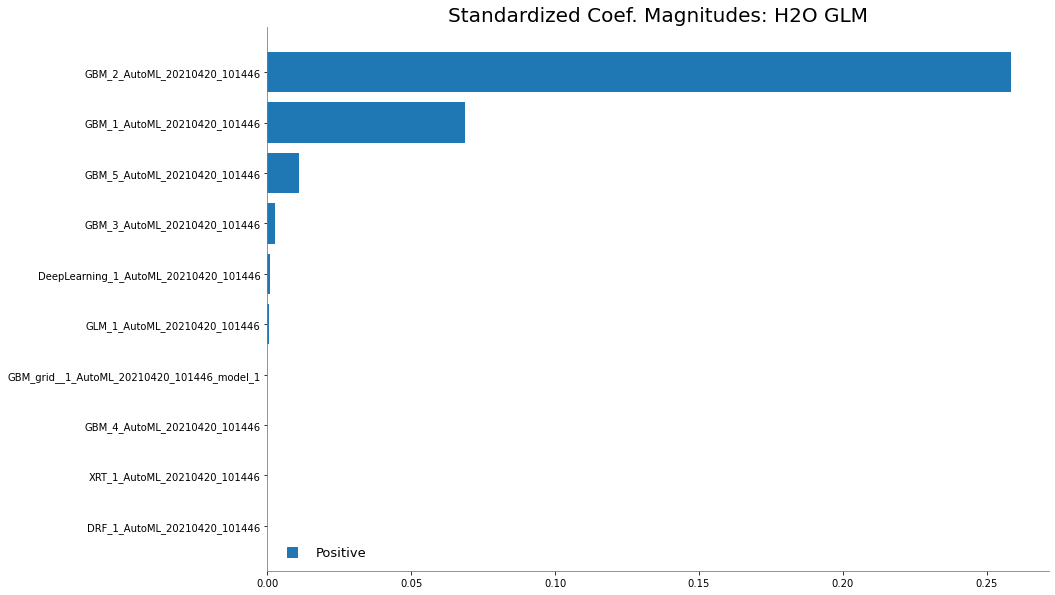

In [149]:
metalearner.std_coef_plot()

In [125]:
h2o.get_model(model_id).metalearner()

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  metalearner_AUTO_StackedEnsemble_AllModels_AutoML_20210420_101446


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,"Elastic Net (alpha = 0.5, lambda = 2.258E-4 )",10,7,1,levelone_training_StackedEnsemble_AllModels_AutoML_20210420_101446




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.22285575425627957
RMSE: 0.47207600474529476
MAE: 0.3577168118937625
RMSLE: 0.12034524870031442
R^2: 0.3259910937609637
Mean Residual Deviance: 0.22285575425627957
Null degrees of freedom: 3861
Residual degrees of freedom: 3854
Null deviance: 1276.9399854672324
Residual deviance: 860.6689229377517
AIC: 5180.128812717147

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 0.2230823259224694
RMSE: 0.4723159174985207
MAE: 0.35789650487089536
RMSLE: 0.12041317556810448
R^2: 0.32530584638448745
Mean Residual Deviance: 0.2230823259224694
Null degrees of freedom: 3861
Residual degrees of freedom: 3854
Null deviance: 1277.1043650451534
Residual deviance: 861.5439427125768
AIC: 5184.053213386263

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.3579374,0.01058328,0.36069974,0.36608687,0.33996028,0.35787547,0.36506465
1,mean_residual_deviance,0.22335783,0.019000858,0.23923838,0.22691321,0.19703366,0.21159321,0.2420107
2,mse,0.22335783,0.019000858,0.23923838,0.22691321,0.19703366,0.21159321,0.2420107
3,null_deviance,255.42087,18.944805,270.14395,279.33765,235.1926,252.05312,240.37706
4,r2,0.32488036,0.029596588,0.3118829,0.34107918,0.34891266,0.34385273,0.27867436
5,residual_deviance,172.30879,13.61599,185.88823,184.02661,153.09515,165.2543,173.27966
6,rmse,0.47225946,0.020274352,0.48912,0.4763541,0.44388473,0.45999262,0.49194583
7,rmsle,0.12039038,0.0044855876,0.123683274,0.121521294,0.11285072,0.120123595,0.12377302



Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective,alpha,lambda,deviance_train,deviance_xval,deviance_se,training_rmse,training_deviance,training_mae,training_r2
0,,2021-04-20 10:15:00,0.000 sec,1,430.334459,0.111579,0.5,0.000226,0.222856,0.223358,0.100249,0.472076,0.222856,0.357717,0.325991



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,GBM_2_AutoML_20210420_101446,2.586545e-01,1.000000,0.755878
1,GBM_1_AutoML_20210420_101446,6.868768e-02,0.265558,0.200729
2,GBM_5_AutoML_20210420_101446,1.095310e-02,0.042346,0.032009
3,GBM_3_AutoML_20210420_101446,2.682023e-03,0.010369,0.007838
4,DeepLearning_1_AutoML_20210420_101446,8.100116e-04,0.003132,0.002367
5,GLM_1_AutoML_20210420_101446,4.030019e-04,0.001558,0.001178
6,GBM_grid__1_AutoML_20210420_101446_model_1,3.978273e-07,0.000002,0.000001
7,GBM_4_AutoML_20210420_101446,0.000000e+00,0.000000,0.000000
8,XRT_1_AutoML_20210420_101446,0.000000e+00,0.000000,0.000000
9,DRF_1_AutoML_20210420_101446,0.000000e+00,0.000000,0.000000


## Generating Predictions Using Leader Model

We can also generate predictions on a test sample using the leader model object.

In [160]:
pred = aml.predict(test_h)
pred.head()

stackedensemble prediction progress: |████████████████████████████████████| 100%


predict
3.04291
3.33913
3.07504
2.75576
2.53321
3.15056
3.24064
3.64364
2.46471
3.31511


This allows us to estimate the out-of-sample (test) MSE and the standard error as well.

In [166]:
pred_2 = pred.as_data_frame()
pred_aml = pred_2.to_numpy()

In [171]:
Y_test = test_h['lwage'].as_data_frame().to_numpy()

In [175]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [176]:
resid_basic = (Y_test-pred_aml)**2

MSE_aml_basic = sm.OLS( resid_basic , np.ones( resid_basic.shape[0] ) ).fit().summary2().tables[1].iloc[0, 0:2]
MSE_aml_basic

Coef.       0.221702
Std.Err.    0.012870
Name: const, dtype: float64

We observe both a lower MSE and a lower standard error compared to our previous results (see [here](https://www.kaggle.com/janniskueck/pm3-notebook-newdata)).

### By using model_performance()
If needed, the standard model_performance() method can be applied to the AutoML leader model and a test set to generate an H2O model performance object.



In [177]:
perf = aml.leader.model_performance(test_h)
perf


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.22170242200808812
RMSE: 0.47085286662405285
MAE: 0.35421853036302176
RMSLE: 0.1205506753003878
R^2: 0.28289300402772755
Mean Residual Deviance: 0.22170242200808812
Null degrees of freedom: 1287
Residual degrees of freedom: 1280
Null deviance: 398.23902107893576
Residual deviance: 285.5527195464175
AIC: 1732.9176833646518
